In [1]:
import re
import regex
import json
import emoji
import emojis
import humanize
import calendar
import datetime
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from dateutil.relativedelta import relativedelta
from collections import Counter

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import seaborn as sns
sns.set()

import PIL.Image
from IPython.display import Image
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

In [3]:
import pickle

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.util import ngrams 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import pyLDAvis.gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_en_spacy
from spacy.lang.es.stop_words import STOP_WORDS as stopwords_sp_spacy

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



### Load my tweets provided by Twitter itself

In [4]:
with open('twitter/data/tweet.js') as f:
    file = f.read()
    file = file[file.find("["):]
    
data = json.loads(file)
print(f"{len(data):,.0f} tweets")
df = json_normalize(data)

16,534 tweets


### Data cleaning

In [5]:
# Remove RTs

df['RTs'] = df['tweet.full_text'].apply(lambda text: text.startswith("RT @"))
RTs = df[df['RTs']]['tweet.full_text'].apply(lambda text: text.split(":")[0]).values

print(df['RTs'].value_counts())
df = df[~df['RTs']]

False    10577
True      5957
Name: RTs, dtype: int64


In [6]:
df.drop(['tweet.id_str',
         'tweet.retweeted', 
         'tweet.favorited',
         'tweet.truncated', 
         'tweet.source', 
         'tweet.possibly_sensitive', 
         'tweet.entities.symbols',
         'tweet.extended_entities.media',
         'tweet.display_text_range', 
         'tweet.in_reply_to_status_id',
         'tweet.in_reply_to_status_id_str', 
         'tweet.in_reply_to_user_id', 
         'tweet.in_reply_to_user_id_str',
         'tweet.coordinates.type', 
         'tweet.coordinates.coordinates', 
         'tweet.geo.type', 
         'tweet.geo.coordinates',
         'RTs'
          ], axis=1, inplace=True)
df.shape

(10577, 11)

In [7]:
def get_urls(obj):
    urls = []
    if len(obj)==0:
        return urls
    for item in obj:
        urls.append(item['expanded_url'])
    return urls

df['urls'] = df['tweet.entities.urls'].apply(lambda obj: get_urls(obj))
df.drop(['tweet.entities.urls'], axis=1, inplace=True)

In [8]:
def get_mentions(obj):
    mentions = []
    if len(obj)==0:
        return mentions
    for item in obj:
        mentions.append(item['screen_name'])
    return mentions

df['mentions'] = df['tweet.entities.user_mentions'].apply(lambda obj: get_mentions(obj))
df.drop(['tweet.entities.user_mentions'], axis=1, inplace=True)

def remove_replies(mentions, replied_to):
    try:
        mentions.remove(replied_to)
        return mentions
    except:
        return mentions

df['mentions'] = df.apply(lambda x: remove_replies(x.mentions, x['tweet.in_reply_to_screen_name']), axis=1)

In [9]:
def get_hashtags(obj):
    hashtags = []
    if len(obj)==0:
        return hashtags
    for item in obj:
        hashtags.append(item['text'])
    return hashtags

df['hashtags'] = df['tweet.entities.hashtags'].apply(lambda obj: get_hashtags(obj))
df.drop(['tweet.entities.hashtags'], axis=1, inplace=True)

In [10]:
def get_media_urls(obj):
    media_urls = []
    try:
        if len(obj)==0:
            return media_urls
    except:
        return media_urls
    for item in obj:
        media_urls.append(item['expanded_url'])
    return media_urls

df['media.urls'] = df['tweet.entities.media'].apply(lambda obj: get_media_urls(obj))
df.drop(['tweet.entities.media'], axis=1, inplace=True)

In [11]:
df = df[['tweet.id',
         'tweet.created_at',
         'tweet.full_text',
         'tweet.lang',
         'tweet.retweet_count',
         'tweet.favorite_count',
         'mentions',
         'tweet.in_reply_to_screen_name',
         'hashtags',
         'urls',
         'media.urls'
         ]]

df.columns = ['id', 'date', 'text', 'lang',
              'retweets', 'favorites', 'mentions', 'replied_to',
              'hashtags', 'urls', 'media_urls']

### Data manipulation

In [12]:
df['date'] = pd.to_datetime(df.date)
df['day'] = df.date.dt.date
df['YYYYMM'] = df.date.dt.to_period('M')
df['year'] = df.date.dt.year
df['dow'] = df.date.dt.day_name()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [13]:
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df['emojis'] = df['text'].apply(lambda text: get_emojis(text))

In [14]:
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(text):
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
             
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")
        
    return text

df['text_clean'] = df['text'].apply(lambda text: text_clean(text))

<>:1: DeprecationWarning:

invalid escape sequence \s

<>:2: DeprecationWarning:

invalid escape sequence \s

<>:1: DeprecationWarning:

invalid escape sequence \s

<>:2: DeprecationWarning:

invalid escape sequence \s

<>:1: DeprecationWarning:

invalid escape sequence \s

<>:2: DeprecationWarning:

invalid escape sequence \s

<ipython-input-14-01c43c42085e>:1: DeprecationWarning:

invalid escape sequence \s

<ipython-input-14-01c43c42085e>:2: DeprecationWarning:

invalid escape sequence \s



In [15]:
df.sample(3)

id                      date  \
4661    778583814763323392 2016-09-21 13:17:01+00:00   
5441    742572946632364032 2016-06-14 04:22:41+00:00   
15768  1091369467504844802 2019-02-01 16:15:32+00:00   

                                                    text lang retweets  \
4661   Vivir en el mismo dormitorio que mis compañero...   es        0   
5441   As of today, I definitely can say that I ❤️❤️❤...   en        2   
15768  Sam Smith es el mejor --- Calvin Harris, Sam S...   en        0   

      favorites   mentions replied_to  hashtags  \
4661          0         []        NaN        []   
5441          3         []        NaN  [ECCO16]   
15768         0  [YouTube]        NaN        []   

                                 urls media_urls         day   YYYYMM  year  \
4661                               []         []  2016-09-21  2016-09  2016   
5441                               []         []  2016-06-14  2016-06  2016   
15768  [https://youtu.be/dTQMd2I3drE]         []  2019-02-01  2019-02  2019   

             dow        emojis  \
4661   Wednesday            []   
5441     Tuesday  [❤️, ❤️, ❤️]   
15768     Friday            []   

                                              text_clean  
4661   Vivir en el mismo dormitorio que mis compañero...  
5441   As of today, I definitely can say that I ❤️❤️❤...  
15768  Sam Smith es el mejor --- Calvin Harris, Sam S...

In [16]:
df['id_url'] = df['id'].apply(lambda text: "https://mobile.twitter.com/user/status/"+text)

### EDA

In [17]:
my_color = "#ff00a7"

In [18]:
print("Time on Twitter with this account:")
print(f"Since {humanize.naturaldate(df.date.min())}")
relativedelta(df.date.max(), df.date.min())

Time on Twitter with this account:
Since Jun 04 2011


relativedelta(years=+9, days=+15, minutes=+42, seconds=+35)

In [19]:
# Plot Day
temp_day = pd.DataFrame(df.day.value_counts())
temp_day.reset_index(inplace=True)
temp_day.columns = ['day', 'tweet_count']
temp_day.sort_values(by=['day'], inplace=True)
temp_day.reset_index(inplace=True, drop=True)
idx = pd.date_range(temp_day.day.min(), temp_day.day.max())
temp_day.index = pd.DatetimeIndex(temp_day.day)
temp_day = temp_day.reindex(idx, fill_value=0)
temp_day.day = temp_day.index
temp_day.reset_index(drop=True, inplace=True)


trace_day = go.Scatter(
                    x=temp_day.day.astype(str).values,
                    y=temp_day.tweet_count.values,
                    text = [f"{humanize.naturaldate(day)}: {count} tweets" for day,count in zip(temp_day.day.dt.date.values,temp_day.tweet_count.values)],
                    hoverinfo='text',
                    mode='lines', 
                    line = {
                        'color': my_color,
                        'width': 1.2
                    },
                    visible=False,
                    name="Day"
                )

# Plot Month
temp_month = temp_day
temp_month.index = pd.DatetimeIndex(temp_month.day)
temp_month = temp_month.groupby(pd.Grouper(freq='M')).sum().reset_index()
idx = pd.date_range(temp_month.day.min(), temp_month.day.max())
temp_month.index = pd.DatetimeIndex(temp_month.day)
temp_month = temp_month.reindex(idx, fill_value=0)
temp_month.day = temp_month.index
temp_month.reset_index(drop=True, inplace=True)
temp_month['YYYYMM'] = temp_month['day'].dt.to_period('M')
temp_month.drop_duplicates(subset=['YYYYMM'], keep='last', inplace=True)


trace_month = go.Scatter(
                    x=temp_month.day.astype('datetime64[M]').astype(str).values,
                    y=temp_month.tweet_count.values,
                    text = [f"{humanize.naturaldate(month)[:3]+humanize.naturaldate(month)[6:]}: {count} tweets" for month,count in zip(temp_month.YYYYMM.values,temp_month.tweet_count.values)],
                    hoverinfo='text',
                    mode='lines', 
                    line = {
                        'color': my_color,
                        'width': 1.2
                    },
                    visible=False,
                    name="Month"
                ) 

# Plot year
temp_year = temp_day
temp_year.index = pd.DatetimeIndex(temp_year.day)
temp_year = temp_year.groupby(pd.Grouper(freq='Y')).sum().reset_index()
temp_year['year'] = temp_year.day.dt.year
temp_year

trace_year = go.Scatter(
                    x=temp_year.day.astype('datetime64[Y]').astype(str).values,
                    y=temp_year.tweet_count.values,
                    text = [f"Year {year}: {count:,.0f} tweets" for year,count in zip(temp_year.year.values,temp_year.tweet_count.values)],
                    hoverinfo='text',
                    mode='lines+markers', 
                    line = {
                        'color': my_color,
                        'width': 1.2
                    },
                    visible=True,
                    name="Year"
                ) 


# Menus
updatemenus = list([
    dict(
         active=0,
         buttons=list([
            dict(label = 'Year',
                 method = 'update',
                 args = [{'visible': [True, False, False]},
                         {'title': 'Number of Tweets per Year'}]),
            dict(label = 'Month',
                 method = 'update',
                 args = [{'visible': [False, True, False]},
                         {'title': 'Number of Tweets per Month'}]),
            dict(label = 'Day',
                 method = 'update',
                 args = [{'visible': [False, False, True]},
                         {'title': 'Number of Tweets per Day'}]),
             ]),
        
    )
])

# Layout
layout = go.Layout(title="Number of Tweets -- Pick a scale",
                   updatemenus=updatemenus,
                  )

fig = go.Figure(data=[trace_year, trace_month, trace_day], layout=layout)
iplot(fig)

In [20]:
temp = pd.DataFrame(df.groupby('day').count()['date'])
temp.reset_index(inplace=True)
temp.columns = ['date', 'tweet_count']
temp['date_human'] = temp['date'].apply(lambda value: humanize.naturaldate(value))
print("Days I tweeted the most:")
temp[['date_human', 'tweet_count']].sort_values('tweet_count', ascending=False)[:5].reset_index(drop=True)

Days I tweeted the most:


date_human  tweet_count
0  Jan 24 2013           62
1  Jul 02 2017           55
2  Mar 14 2015           48
3  Jan 26 2015           46
4  Dec 20 2012           35

In [21]:
temp['date'] = pd.to_datetime(temp['date'])
temp = temp[temp['date'].dt.year > 2012]
temp['diff'] = temp['date'].diff().dt.days
temp['date'] = temp['date'].apply(lambda value: humanize.naturaldate(value))
print("Longest streaks without tweeting:")
temp[['date_human', 'diff']].sort_values('diff', ascending=False)[:5].reset_index(drop=True)

Longest streaks without tweeting:


date_human  diff
0  Aug 10 2019  48.0
1  Jan 10 2019   9.0
2  Mar 22 2016   8.0
3  Mar 09 2014   8.0
4  Jul 13 2015   7.0

In [22]:
temp = pd.DataFrame(df['lang'].value_counts()).reset_index()
temp.columns = ['language', 'tweet_count']

lang_dict = {'es': 'Spanish',
             'en': 'English',
             'pt': 'Portuguese',
             'ru': 'Russian',
             'fr': 'French',
             'ja': 'Japanese'}

# Others will include: mixed, one-word, one-emoji, missclasified, and otherss

temp['language'] = temp['language'].apply(lambda lg: lang_dict[lg] if lg in lang_dict.keys() else 'Others')
temp = temp.groupby('language').sum().sort_values('tweet_count', ascending=False).reset_index()

# Plot
trace = go.Bar(
                x=temp.language.values,
                y=temp.tweet_count.values,
                opacity=0.6,
                marker=dict(color=my_color,
                            line=dict(color=my_color,width=1.5,)
                           ),
                )

layout = go.Layout(title='Number of tweets per language<br> ALL TIME',
                   yaxis=dict(tickformat=','))

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [23]:
traces = []

lang_color_dict = {'Spanish': "#f4ce26",
                   'English': "#2093dd",
                   'Portuguese': "#037f3e",
                   'Russian': "#2135a3",
                   'French': "#dd3228",
                   'Japanese': "#b666de"}

temp = df[['lang', 'YYYYMM']]
temp['language'] = temp['lang'].apply(lambda lg: lang_dict[lg] if lg in lang_dict.keys() else 'Others')
temp = temp[temp['language']!='Others']
temp['YYYYMM'] = temp['YYYYMM'].dt.strftime('%Y-%m')
temp = temp.groupby(['language', 'YYYYMM'])['language'].count()
temp = pd.DataFrame(temp / temp.groupby(level=1).sum())
temp.columns = ['pct']
temp.reset_index(inplace=True)

for lang in temp['language'].unique():
    trace= go.Scatter(
                        x=temp[temp['language']==lang].YYYYMM.values,
                        y=temp[temp['language']==lang].pct.values,
                        mode='lines', 
                        line = {
                            'color': lang_color_dict[lang],
                            'width': 1.2
                        },
                        name=lang
                    ) 

    traces.append(trace)
    
layout = go.Layout(title='Percentage of tweets per language',
                   yaxis=dict(tickformat=',.0%'))

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
pd.set_option('display.max_colwidth', -1)
df.retweets = pd.to_numeric(df.retweets)
print(f"Max number of retweets: {df.retweets.max()}")

df[['day', 'text_clean', 'retweets', 'favorites', 'id_url']].sort_values('retweets', ascending=False).head(5).reset_index(drop=True)

Max number of retweets: 163


day  \
0  2018-07-31   
1  2013-01-24   
2  2018-01-03   
3  2017-05-27   
4  2020-06-17   

                                                                                                                          text_clean  \
0  Qué bonitas son las matemáticas 🤩😍                                                                                                  
1   almorzaste en las tardes viendo Padres e Hijos. Jajajaja                                                                           
2  Año nuevo, pero cordialmente les sigo trayendo los malos chistes matemáticos.                                                       
3  Por si quieren saber de dónde salieron muchos símbolos usados en las matemáticas:                                                   
4  Si me dieran la oportunidad de vivir un amor de esta vida una vez más, escogería volver a estudiar matemáticas por primera vez ♥️   

   retweets favorites  \
0  163       470        
1  83        24         
2  49        72         
3  17        26         
4  14        203        

                                                       id_url  
0  https://mobile.twitter.com/user/status/1024364875676495872  
1  https://mobile.twitter.com/user/status/294309322689757184   
2  https://mobile.twitter.com/user/status/948588277065551875   
3  https://mobile.twitter.com/user/status/868510141183864832   
4  https://mobile.twitter.com/user/status/1273069320659177479

In [25]:
pd.set_option('display.max_colwidth', -1)
df.favorites = pd.to_numeric(df.favorites)
print(f"Max number of favorites: {df.favorites.max()}")

df[['day', 'text_clean', 'retweets', 'favorites', 'id_url']].sort_values('favorites', ascending=False).head(5).reset_index(drop=True)

Max number of favorites: 470


day  \
0  2018-07-31   
1  2020-06-17   
2  2018-01-03   
3  2019-04-12   
4  2017-08-29   

                                                                                                                                                                                                                                          text_clean  \
0  Qué bonitas son las matemáticas 🤩😍                                                                                                                                                                                                                  
1  Si me dieran la oportunidad de vivir un amor de esta vida una vez más, escogería volver a estudiar matemáticas por primera vez ♥️                                                                                                                   
2  Año nuevo, pero cordialmente les sigo trayendo los malos chistes matemáticos.                                                                                                                                                                       
3  Advice from Hilary Parker (@ Stitchfix) “Practice data science in your everyday life to build up your skills... create your own finance dashboard, come up with a pipeline for your tasks, study the variance around your commuting time, etc”.     
4  Todo un éxito hoy la presentación de  en el                                                                                                                                                                                                         

   retweets  favorites  \
0  163       470         
1  14        203         
2  49        72          
3  9         51          
4  5         41          

                                                       id_url  
0  https://mobile.twitter.com/user/status/1024364875676495872  
1  https://mobile.twitter.com/user/status/1273069320659177479  
2  https://mobile.twitter.com/user/status/948588277065551875   
3  https://mobile.twitter.com/user/status/1116777426082652160  
4  https://mobile.twitter.com/user/status/902549141280174080

In [26]:
Counter(sum(df['mentions'].values,[])).most_common(10)

[('YouTube', 200),
 ('K_MateIng', 69),
 ('ukonradlorenz', 55),
 ('9GAG', 55),
 ('RCScientific7', 41),
 ('alejatorresm', 40),
 ('ELTIEMPO', 38),
 ('K_AstroK', 32),
 ('lau08acuna', 30),
 ('ViveKonradio', 26)]

In [27]:
df['replied_to'].value_counts()[:11]

vivmarquez        758
Alejo_Jauregui    104
RCScientific7     91 
ja0335            86 
CarlosADiez       44 
derjav            43 
vladimirphy       29 
NaomiHdC          25 
angienxo          24 
astrosvd          24 
ivonnewrites      23 
Name: replied_to, dtype: int64

In [28]:
Counter(RTs).most_common(10)

[('RT @K_AstroK', 201),
 ('RT @zuluagajorge', 161),
 ('RT @astrosvd', 160),
 ('RT @ukonradlorenz', 158),
 ('RT @juanripu', 139),
 ('RT @edusadeci', 116),
 ('RT @K_MateIng', 94),
 ('RT @intiwatay', 84),
 ('RT @FedericoArdila', 82),
 ('RT @CarlosADiez', 80)]

In [29]:
print(f"Total tweets: 16,534")
print(f"From which...")
print(f"5,957 are re-tweets")
print(f"{df['replied_to'].isna().value_counts()[False]:,.0f} are replies")
print(f"{sum(df['urls'].apply(lambda value: True if len(value)!=0 else False) | df['media_urls'].apply(lambda value: True if len(value)!=0 else False)):,.0f} have media")

Total tweets: 16,534
From which...
5,957 are re-tweets
1,990 are replies
3,945 have media


In [30]:
Counter(sum(df['urls'].values,[])).most_common(5)

[('http://www.konradio.co', 21),
 ('http://www.lavozdelderecho.com', 5),
 ('http://www.spacetelescope.org/projects/fits_liberator/improc/', 3),
 ('http://www.vivianamarquez.com', 3),
 ('http://wp.me/p1Ha4L-1J', 3)]

 HASHTAGS (Tableau)

In [31]:
temp_year = []

for year in list(range(2011,2021)):
    temp = pd.DataFrame(Counter(sum(df[df['year']==year]['hashtags'].values,[])).most_common(30))
    temp['year'] = year
    temp_year.append(temp)
    
temp_year = pd.concat(temp_year)
temp_year.columns = ['hashtag', 'tweet_count', 'year']

temp_year.to_csv("hashtag.csv")

In [32]:
vader = SentimentIntensityAnalyzer() 

def transform_emoji(es):
    if len(es)==0:
        return []
    
    result = []
    for e in es:
        e_string = emoji.demojize(e)[1:-1].replace("_"," ")
        e_list = [(emoji, name) for emoji, name in vader.emojis.items() if e_string==name]
        if len(e_list)==0:
            result.append(e)
            continue
        result.append(e_list[0][0])
    return result

df['emojis'] = df['emojis'].apply(lambda es: transform_emoji(es))

In [33]:
# All time
print(f"{sum(list(Counter(sum(df['emojis'].values,[])).values())):,.0f} emojis")
print(f"{len(Counter(sum(df['emojis'].values,[])).most_common())} different ones\n\n")
      
for i, em in enumerate(Counter(sum(df['emojis'].values,[])).most_common()):
    e = em[0]
    print(e)
    print(f"Rank #{i+1}")
    print(f"Count: {em[1]}")
    try:
        print(f"Sentiment: {vader.polarity_scores(e)['compound']}")
        print(f"Category: {emojis.db.get_emoji_by_code(e).category}")
        print()
    except:
        print("NA************************************************")
        print()

3,798 emojis
289 different ones


😂
Rank #1
Count: 579
Sentiment: 0.4404
Category: Smileys & Emotion

😍
Rank #2
Count: 217
Sentiment: 0.4588
Category: Smileys & Emotion

❤️
Rank #3
Count: 156
Sentiment: 0.0
Category: Smileys & Emotion

😀
Rank #4
Count: 149
Sentiment: 0.3612
Category: Smileys & Emotion

😄
Rank #5
Count: 147
Sentiment: 0.6705
Category: Smileys & Emotion

😱
Rank #6
Count: 107
Sentiment: -0.7003
Category: Smileys & Emotion

😊
Rank #7
Count: 99
Sentiment: 0.7184
Category: Smileys & Emotion

🤣
Rank #8
Count: 90
Sentiment: 0.4939
Category: Smileys & Emotion

♥️
Rank #9
Count: 78
Sentiment: 0.6369
Category: Activities

💛
Rank #10
Count: 78
Sentiment: 0.6369
Category: Smileys & Emotion

🤔
Rank #11
Count: 70
Sentiment: 0.0
Category: Smileys & Emotion

😭
Rank #12
Count: 69
Sentiment: -0.4767
Category: Smileys & Emotion

☺️
Rank #13
Count: 64
Sentiment: 0.4588
Category: Smileys & Emotion

😅
Rank #14
Count: 63
Sentiment: 0.3612
Category: Smileys & Emotion

🎉
Rank #15
Count: 61
Sent

🖐️
Rank #250
Count: 1
Sentiment: 0.4939
NA************************************************

😦
Rank #251
Count: 1
Sentiment: -0.34
Category: Smileys & Emotion

🐬
Rank #252
Count: 1
Sentiment: 0.0
Category: Animals & Nature

🐒
Rank #253
Count: 1
Sentiment: 0.0
Category: Animals & Nature

🇸🇻
Rank #254
Count: 1
Sentiment: 0.0
Category: Flags

🥵
Rank #255
Count: 1
Sentiment: 0.0
Category: Smileys & Emotion

🚫
Rank #256
Count: 1
Sentiment: 0.0
Category: Symbols

🇯🇵
Rank #257
Count: 1
Sentiment: 0.0
Category: Flags

🇹🇷
Rank #258
Count: 1
Sentiment: 0.0
Category: Flags

🇫🇷
Rank #259
Count: 1
Sentiment: 0.0
Category: Flags

🇮🇹
Rank #260
Count: 1
Sentiment: 0.0
Category: Flags

🇮🇳
Rank #261
Count: 1
Sentiment: 0.0
Category: Flags

🇮🇩
Rank #262
Count: 1
Sentiment: 0.0
Category: Flags

💅
Rank #263
Count: 1
Sentiment: 0.0
Category: People & Body

🐩
Rank #264
Count: 1
Sentiment: 0.0
Category: Animals & Nature

🐕‍🦺
Rank #265
Count: 1
Sentiment: 0.0
Category: Animals & Nature

🌭
Rank #266
Count: 1
Sen

In [34]:
# Per year
temp_emoji = []

for year in list(range(2011,2021)):
    temp = pd.DataFrame(Counter(sum(df[df['year']==year]['emojis'].values,[])).most_common(10))
    temp['year'] = year
    temp_emoji.append(temp)
    
temp_emoji = pd.concat(temp_emoji)
temp_emoji.columns = ['emojis', 'tweet_count', 'year']

temp_emoji = temp_emoji.pivot(index='emojis', columns='year').reset_index()
temp_emoji.columns = ['emojis'] + list(temp_emoji.columns.get_level_values(1)[1:])

# I hard-coded the colors because all emoji libraries out there suck!
gray = '#d2d2d0' # Others
green = '#9ae397' # Nature
yellow = '#fbf690' # Happy
orange = '#ffbe6d' # Travel
pink = '#ff6dbe' # Hearts
blue = '#6dbeff' # Sad

emojis_colors = [gray, green, green, yellow, pink, gray, orange, yellow, yellow, green, 
                 pink, orange, orange, gray, yellow, yellow, yellow, pink, pink, pink, 
                 pink, yellow, yellow, yellow, yellow, yellow, yellow, yellow, yellow, yellow, 
                 blue, blue, blue, blue, blue, yellow, blue, yellow, blue]

temp_emoji['colors'] = emojis_colors

In [35]:
beg = 2014
listOfFrames = []
for year in range(beg,2021):
    temp = temp_emoji[['emojis', year, 'colors']]
    temp = temp.sort_values(year, ascending=False).dropna()
    
    trace = go.Bar(
                x=temp.emojis.values,
                y=temp[year].values,
                textposition = "outside",
                texttemplate = "%{x}<br>%{y}",
                textfont = {'size': [14]*10},
                hoverinfo='none', 
                opacity=1,
                marker=dict(color=temp.colors.values,
                           ),
                cliponaxis = False
                )

    layout = go.Layout(title=f'Emojis in {year}',
                       xaxis = {"range":[-1,10],"autorange": False, "showline":False,"tickangle":-90, "visible":False},
                       yaxis = {"range":[-1,200],"autorange": False, "showline":False, "visible":False},
                       plot_bgcolor= '#FFFFFF')
    listOfFrames.append(go.Frame(data=[trace], layout=layout))
    
frames=list(listOfFrames)

year = beg
temp = temp_emoji[['emojis', year, 'colors']]
temp = temp.sort_values(year, ascending=False).dropna()

# Plot
trace = go.Bar(
                x=temp.emojis.values,
                y=temp[year].values,
                textposition = "outside",
                texttemplate = "%{x}<br>%{y}",
                textfont = {'size': [14]*10},
                hoverinfo='none', 
                opacity=1,
                marker=dict(color=temp.colors.values,
                           ),
                cliponaxis = False
                )

layout = go.Layout(title=f'Emojis in {year}',
                   xaxis = {"range":[-1,10],"autorange": False, "showline":False,"tickangle":-90, "visible":False},
                   yaxis = {"range":[-1,200],"autorange": False, "showline":False, "visible":False},
                   plot_bgcolor= '#FFFFFF',
                   updatemenus=[dict(type="buttons",
                                     buttons=[dict(label="▶️",
                                                   method="animate",
                                                   args=[None, {"frame": {"duration": 800, "redraw": True},
                                                                "fromcurrent": True}]),
                                              {
                "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "⏸️",
                "method": "animate"
            }
                                             ]
                                    )
                               ]
                  )

fig = go.Figure(data=[trace], layout=layout, frames=frames)

fig.show()

In [36]:
# Per month
temp_emoji = []

for ym in sorted(df.YYYYMM.unique()):
    temp = pd.DataFrame(Counter(sum(df[df['YYYYMM']==ym]['emojis'].values,[])).most_common(5))
    temp['YYYYMM'] = ym
    if temp.shape[0] != 0:
        temp_emoji.append(temp)
    
temp_emoji = pd.concat(temp_emoji)
temp_emoji.columns = ['emojis', 'tweet_count', 'YYYYMM']

temp_emoji = temp_emoji.pivot(index='emojis', columns='YYYYMM').reset_index()
temp_emoji.columns = ['emojis'] + list(temp_emoji.columns.get_level_values(1)[1:])

# I hard-coded the colors because all emoji libraries out there suck!
gray = '#d2d2d0' # Others
green = '#9ae397' # Nature
yellow = '#fbf690' # Happy
orange = '#ffbe6d' # Travel
pink = '#ff6dbe' # Hearts
blue = '#6dbeff' # Sad
purple = "#be6dff" # Celebration

emojis_colors = [gray, green, green, gray, blue, yellow, pink, gray, orange, yellow, 
                 yellow, green, green, pink, orange, orange, orange, orange, orange, green, 
                 green, green, green, purple, purple, purple, purple, purple, gray, gray, 
                 green, gray, gray, yellow, yellow, yellow, gray, pink, pink, pink, 
                 pink, pink, gray, yellow, gray, gray, yellow, yellow, yellow, yellow, 
                 yellow, yellow, yellow, yellow, yellow, blue, blue, blue, blue, yellow, 
                 blue, blue, blue, blue, blue, blue, blue, blue, blue, blue, 
                 yellow, blue, yellow, blue, yellow, yellow, yellow, yellow, yellow, yellow, 
                 gray, blue, gray, yellow, yellow, yellow, blue, yellow, blue, green]

temp_emoji['colors'] = emojis_colors

In [37]:
beg = temp_emoji.columns[13]
listOfFrames = []
for year in temp_emoji.columns[1:-1]:
    temp = temp_emoji[['emojis', year, 'colors']]
    temp = temp.sort_values(year, ascending=True).dropna()
    if temp.shape[0]!=5:
        continue
    
    trace = go.Bar(
                y=temp.emojis.values,
                x=temp[year].values,
                orientation='h',
                textposition = "outside",
                texttemplate = "%{x}",
                textfont = {'size': [10]*10},
                hoverinfo='none', 
                opacity=1,
                marker=dict(color=temp.colors.values,
                           ),
                cliponaxis = False
                )

    layout = go.Layout(title=f'Emojis in {calendar.month_name[humanize.naturaltime(year).month]} {humanize.naturaltime(year).year}',
                       yaxis = {"range":[-1,5],"autorange": False, "showline":False, "visible":True},
                       xaxis = {"range":[-1,150],"autorange": False, "showline":False, "visible":False},
                       plot_bgcolor= '#FFFFFF')
    listOfFrames.append(go.Frame(data=[trace], layout=layout))
    
frames=list(listOfFrames)

year = beg
temp = temp_emoji[['emojis', year, 'colors']]
temp = temp.sort_values(year, ascending=True).dropna()

# Plot
trace = go.Bar(
                y=temp.emojis.values,
                x=temp[year].values,
                orientation='h',
                textposition = "outside",
                texttemplate = "%{x}",
                textfont = {'size': [10]*10},
                hoverinfo='none', 
                opacity=1,
                marker=dict(color=temp.colors.values,
                           ),
                cliponaxis = False
                )

layout = go.Layout(title=f'Emojis in {calendar.month_name[humanize.naturaltime(year).month]} {humanize.naturaltime(year).year}',
                   yaxis = {"range":[-1,5],"autorange": False, "showline":False, "visible":True},
                   xaxis = {"range":[-1,150],"autorange": False, "showline":False, "visible":False},
                   plot_bgcolor= '#FFFFFF',
                   updatemenus=[dict(type="buttons",
                                     buttons=[dict(label="▶️",
                                                   method="animate",
                                                   args=[None, {"frame": {"duration": 1200, "redraw": True},
                                                                "fromcurrent": True}]),
                                              {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "⏸️",
                "method": "animate"
            }
                                             ]
                                    )
                               ]
                  )

fig = go.Figure(data=[trace], layout=layout, frames=frames)

fig.show()

In [38]:
all_text = re.sub("[^'’ \w]|_"," ", " ".join(df['text_clean'].values))
words = [word for word in all_text.split() if len(word)>2]

print(f"Total characters written: {len(all_text):,.0f}")
print(f"Number of words: ± {len(words):,.0f}")
print(f"Number of unique words: ± {len(set(words)):,.0f}")

Total characters written: 817,618
Number of words: ± 100,986
Number of unique words: ± 20,028


<>:1: DeprecationWarning:

invalid escape sequence \w

<>:1: DeprecationWarning:

invalid escape sequence \w

<>:1: DeprecationWarning:

invalid escape sequence \w

<ipython-input-38-daaa2eb09621>:1: DeprecationWarning:

invalid escape sequence \w



In [71]:
stopwords_en = stopwords.words('english')
stopwords_sp = stopwords.words('spanish')
sw = set(stopwords_en + stopwords_sp + list(stopwords_en_spacy) + list(stopwords_sp_spacy))
sw.add("can't")
sw.add("like")


words_long2 = [word for word in words if len(word)>2]
words_long3 = [word for word in words if len(word)>3]
words_long4 = [word for word in words if len(word)>4]

words_sw2 = [word for word in words_long2 if word.lower() not in sw]
words_sw3 = [word for word in words_long3 if word.lower() not in sw]
words_sw4 = [word for word in words_long4 if word.lower() not in sw]

In [40]:
print("Top words used:\n")
Counter(words_sw4).most_common()[:10]

Top words used:



[('matemáticas', 220),
 ('Colombia', 177),
 ('mundo', 171),
 ('Bogotá', 163),
 ('jajaja', 140),
 ('clase', 132),
 ('Brasil', 125),
 ('semana', 124),
 ('feliz', 123),
 ('mañana', 117)]

In [41]:
n_gram = 2
Counter(ngrams(words_sw2, n_gram)).most_common(50)

[(('San', 'Francisco'), 71),
 (('Carl', 'Sagan'), 34),
 (('São', 'Paulo'), 32),
 (('Palm', 'Beach'), 23),
 (('redes', 'sociales'), 18),
 (('feel', 'like'), 17),
 (('muitas', 'saudades'), 17),
 (('New', 'York'), 15),
 (('números', 'primos'), 13),
 (('Sailor', 'Moon'), 13),
 (('aire', 'momentos'), 13),
 (('estudiar', 'matemáticas'), 12),
 (("I'm", 'excited'), 12),
 (('years', 'ago'), 12),
 (('García', 'Márquez'), 12),
 (('Bay', 'Area'), 11),
 (('número', 'primo'), 11),
 (('Villa', 'Leyva'), 11),
 (('Machine', 'Learning'), 10),
 (('Anoche', 'soñé'), 10),
 (("I'm", 'gonna'), 10),
 (('high', 'school'), 9),
 (('absolutely', 'love'), 9),
 (("I'm", 'glad'), 9),
 (('Robin', 'Schulz'), 9),
 (('Página', '365'), 9),
 (('looks', 'like'), 8),
 (("can't", 'believe'), 8),
 (('función', 'gamma'), 8),
 (('awkward', 'moment'), 8),
 (('Acabé', 'descubrir'), 8),
 (('seres', 'humanos'), 8),
 (('álgebra', 'lineal'), 8),
 (('problema', 'reinas'), 8),
 (('Miss', 'Universo'), 8),
 (('función', 'Gamma'), 8),
 ((

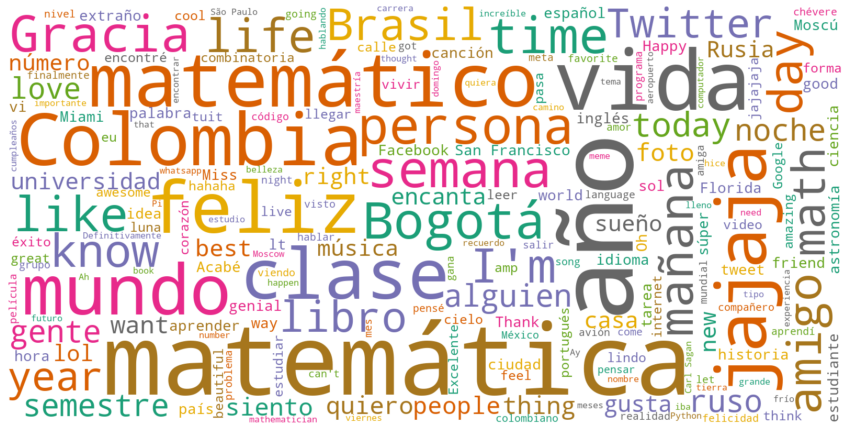

In [42]:
words = all_text
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=sw,
                      background_color='white', colormap='Dark2').generate(words)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

In [43]:
def most_frequent_words_visualization(df, col='text', title="", color_palette="Dark2"):
        '''
        input: data frame with tweets.
        output: word cloud with most frequent words from column "text", i.e., the tweets themselves.
        '''
        words = " ".join(sum(df[col].values,[]))
        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, 
                              background_color='white', colormap=color_palette).generate(words)
        plt.figure(figsize=(15,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis("off")
        plt.show()

In [44]:
def processed_text(text_clean):
    text_clean = text_clean.replace("’","'")
    text_clean = re.sub("[^'’ \w]|_"," ", text_clean)
    words = [word for word in text_clean.split() if (len(word)>2) and (word.lower() not in sw)]
    return words

df['processed_text'] = df['text_clean'].apply(lambda tc: processed_text(tc))

<>:3: DeprecationWarning:

invalid escape sequence \w

<>:3: DeprecationWarning:

invalid escape sequence \w

<>:3: DeprecationWarning:

invalid escape sequence \w

<ipython-input-44-974a9aa24032>:3: DeprecationWarning:

invalid escape sequence \w



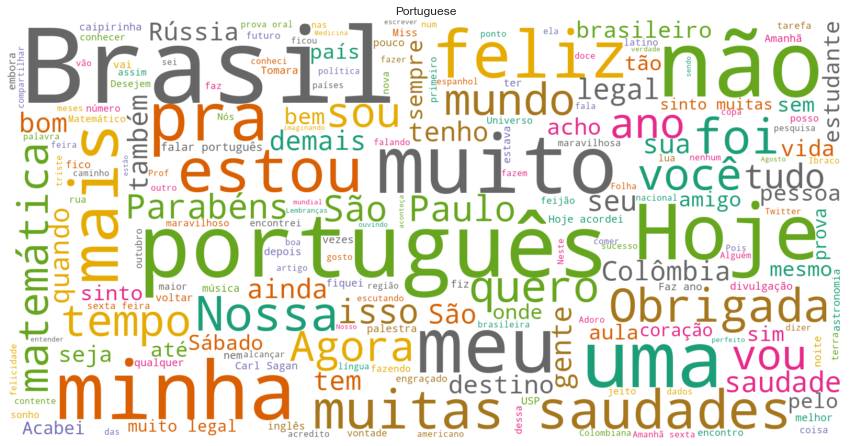

In [45]:
most_frequent_words_visualization(df[df['lang']=='pt'], 'processed_text', "Portuguese")

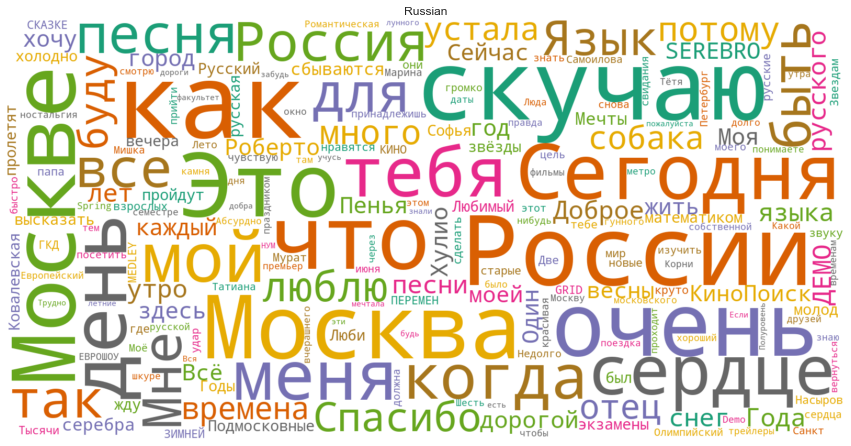

In [46]:
most_frequent_words_visualization(df[df['lang']=='ru'], 'processed_text', "Russian")

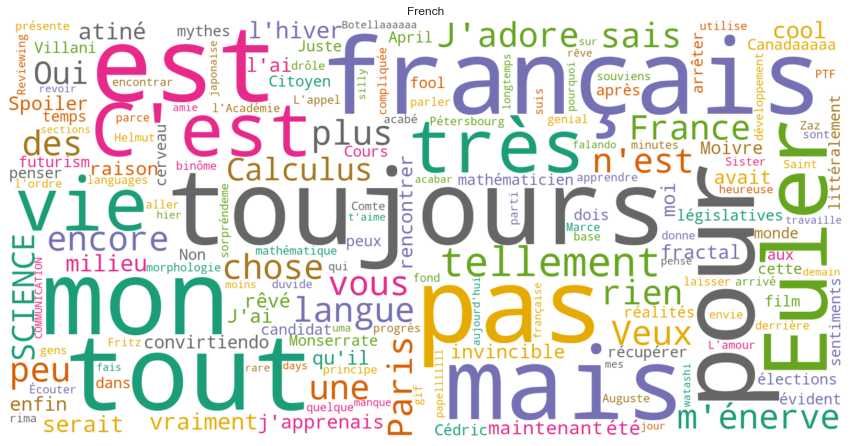

In [47]:
most_frequent_words_visualization(df[df['lang']=='fr'], 'processed_text', "French")

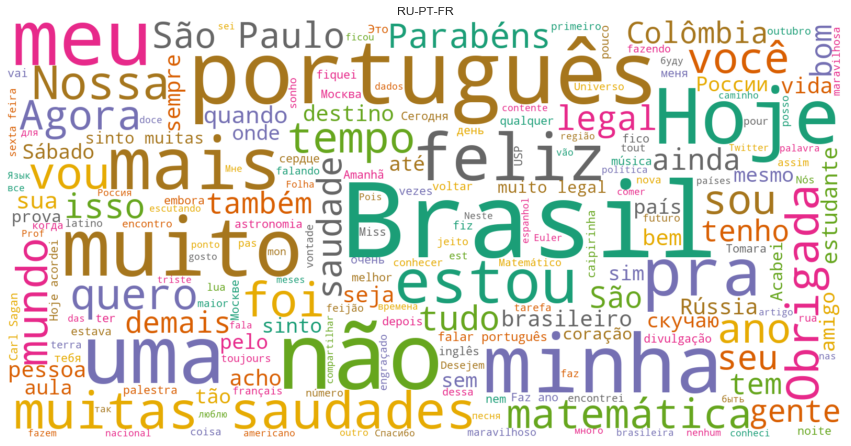

In [48]:
most_frequent_words_visualization(df[df['lang'].isin(['ru', 'pt', 'fr'])], 'processed_text', "RU-PT-FR")

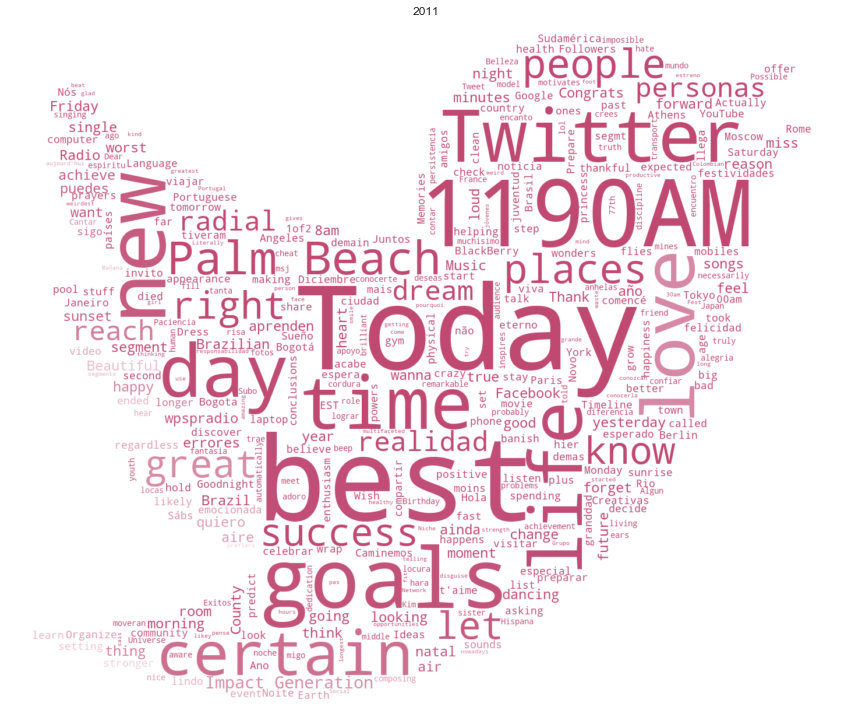

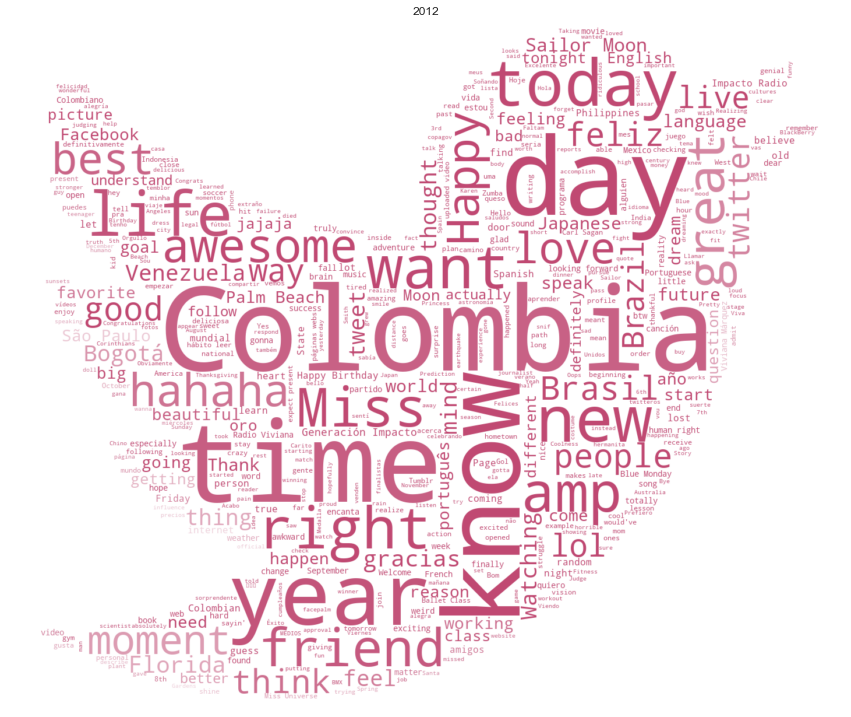

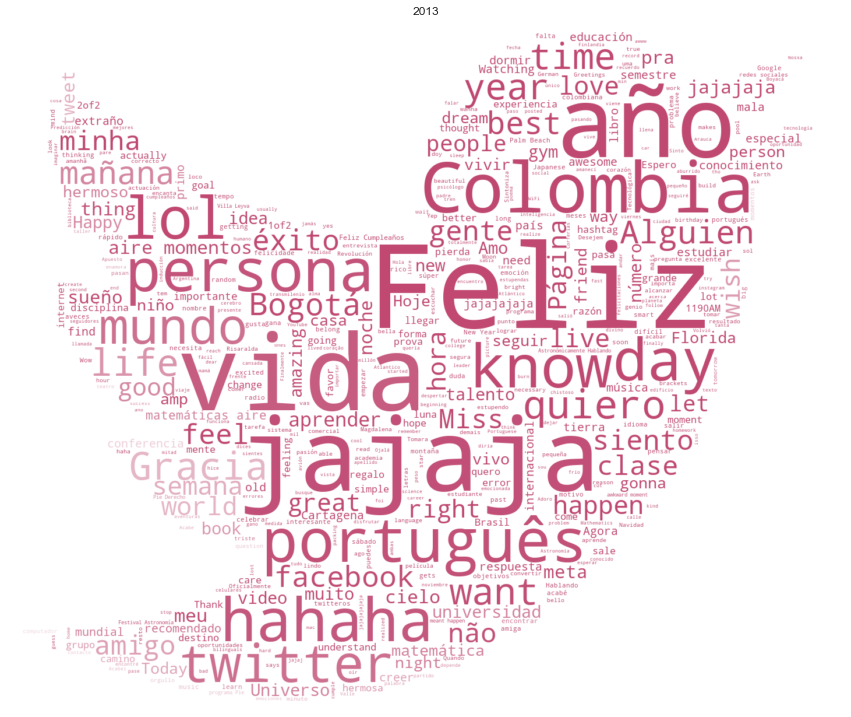

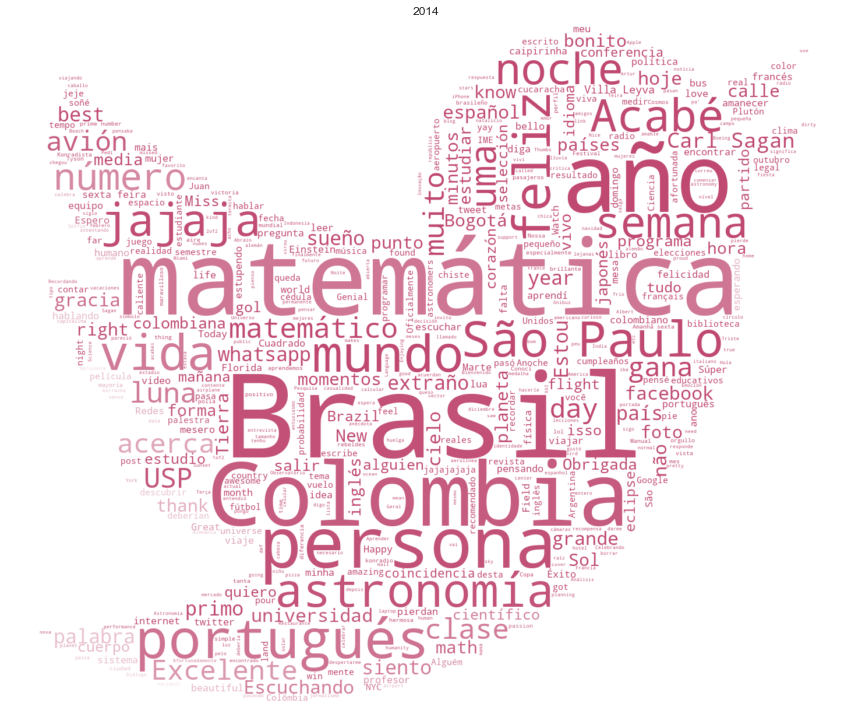

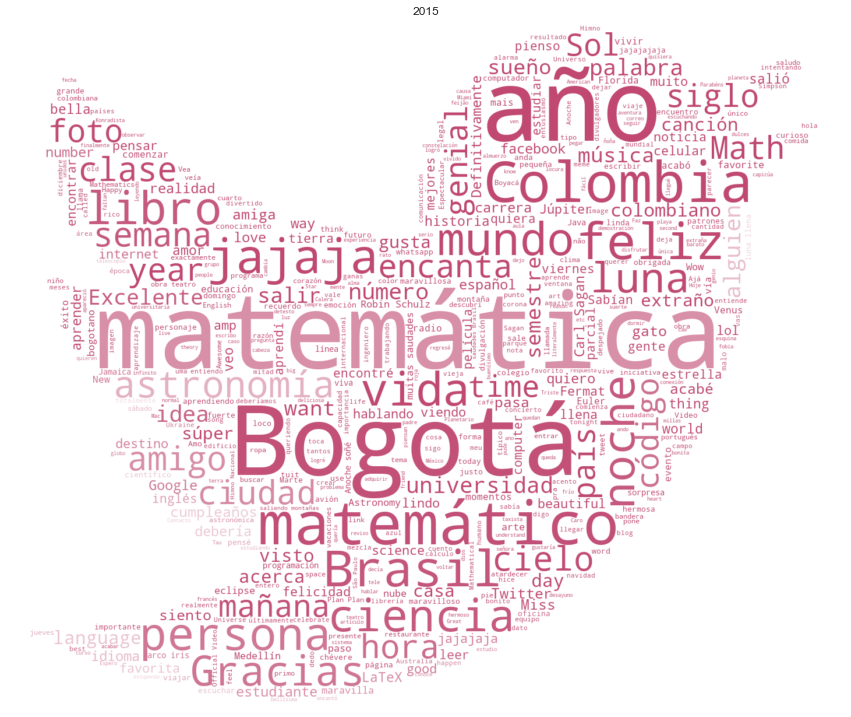

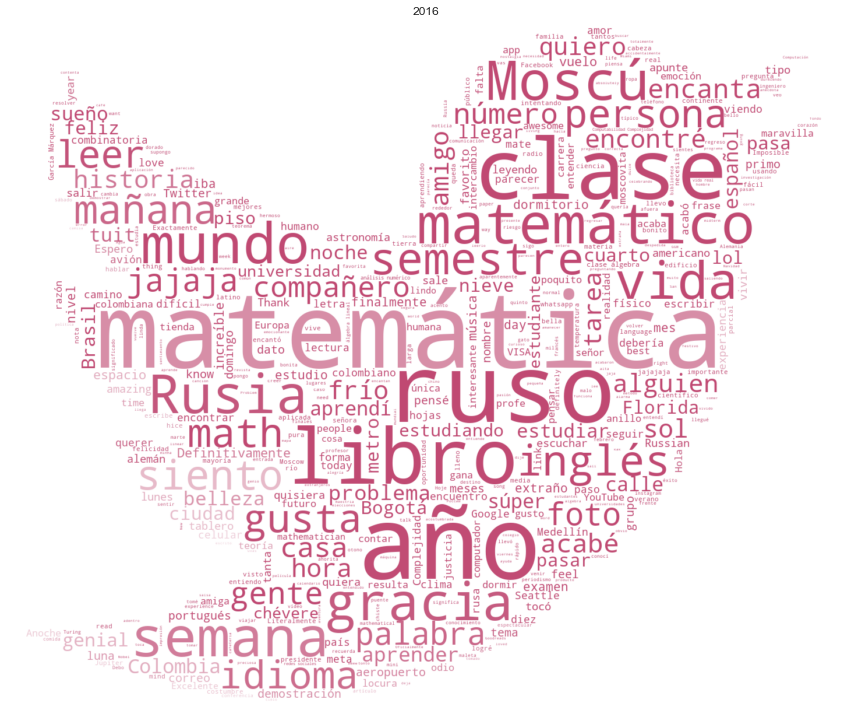

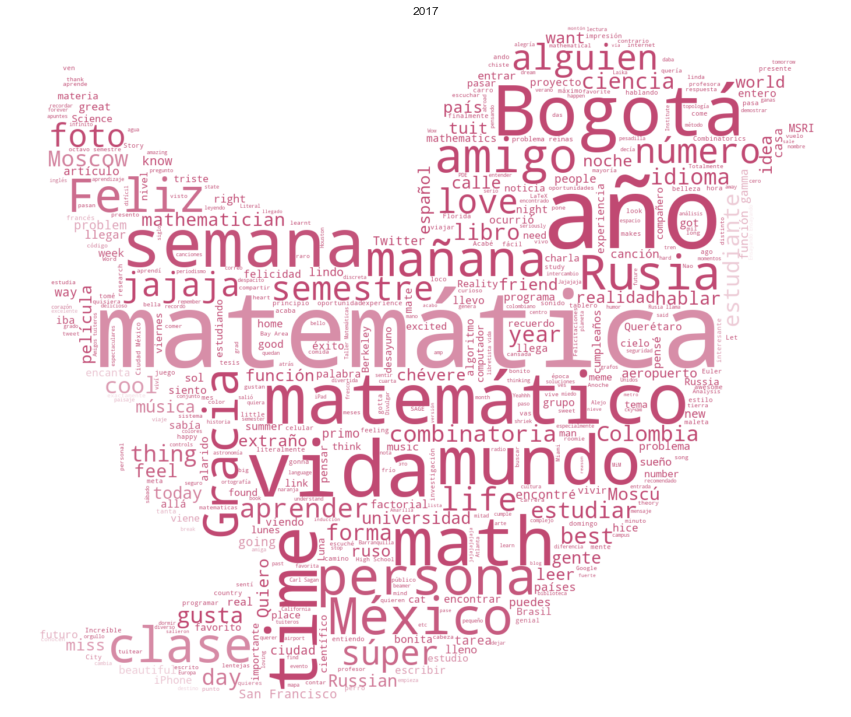

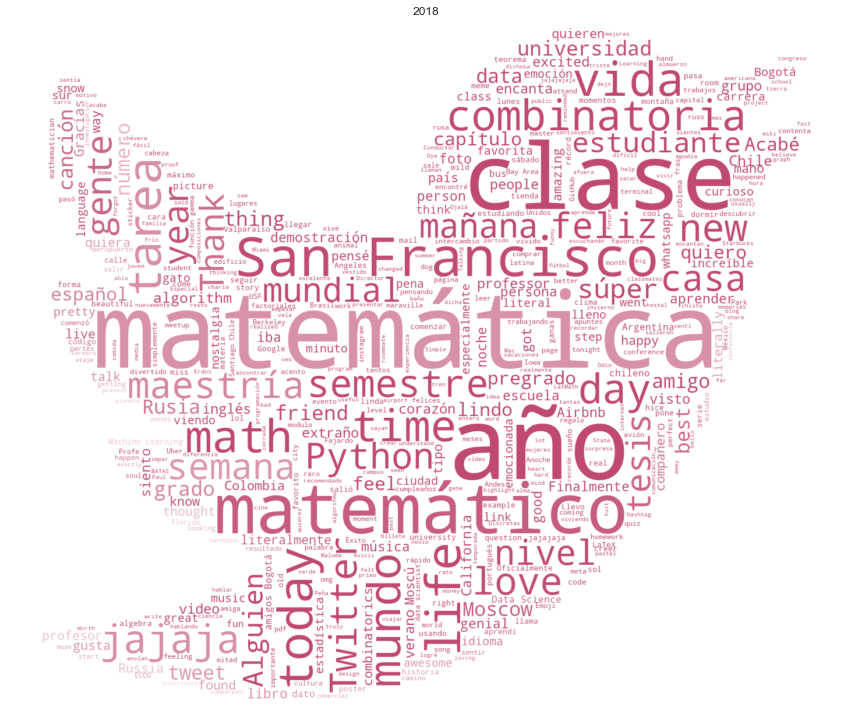

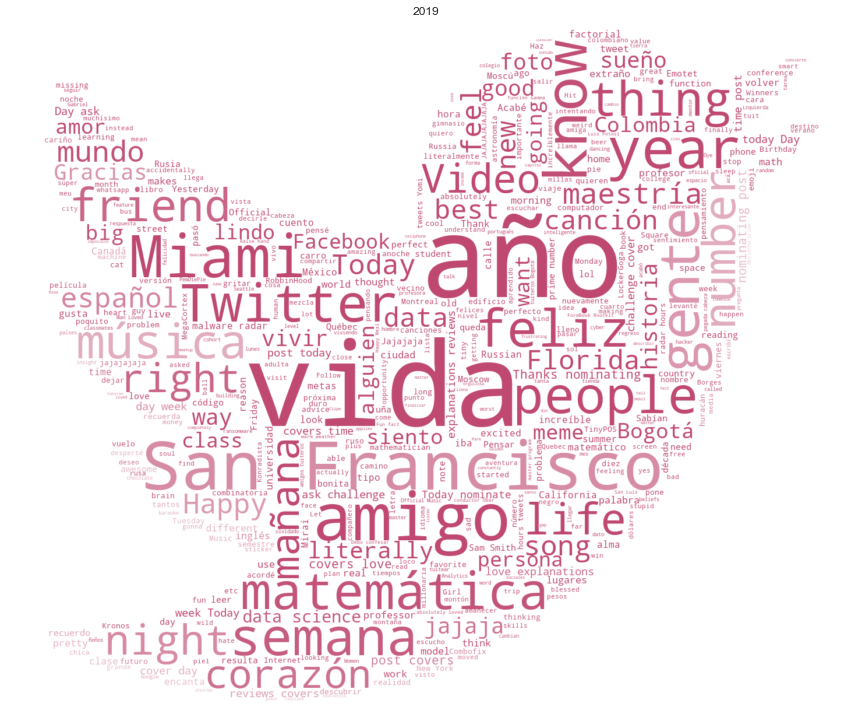

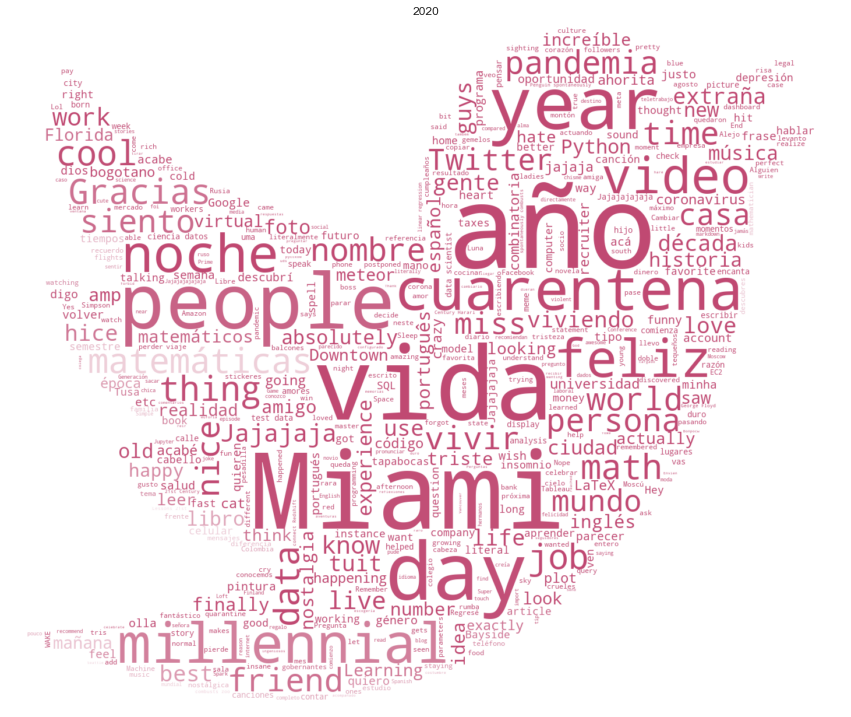

In [49]:
for year in sorted(df.year.unique()):
    mask = np.array(PIL.Image.open("twitter.png"))
    words = " ".join(sum(df[df['year']==year]['processed_text'].values,[]))
    wc = WordCloud(background_color="white", mode="RGBA", max_words=500, max_font_size=200, mask=mask).generate(words)
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=(15,15));
    plt.title(year);
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear');
    plt.axis("off");
    plt.show();

In [72]:
englishStemmer=SnowballStemmer("english")
spanishStemmer=SnowballStemmer("spanish")
    
def text_processed_lemma(text, stemmer):
    text = [stemmer.stem(w) for w in text if (len(w)>3) and (w not in sw)]
    if len(text)<4:
        return None
    return text

def get_doc_top_n(text_processed_lemma, n):
    d = dictionary.doc2bow(text_processed_lemma)
    topics = ldamodel.get_document_topics(d)
    try:
        return topics[n][1]
    except:
        return None

In [78]:
df_english = df[df['lang']=='en']
df_english['text_processed_lemma'] = df_english['processed_text'].apply(lambda text: text_processed_lemma(text, englishStemmer))
df_english = df_english.dropna(subset=['text_processed_lemma'])
df_english = df_english[df_english.index.isin(df_english['text_processed_lemma'].apply(tuple, 1).drop_duplicates().index)]

dictionary = corpora.Dictionary(list(df_english.text_processed_lemma.values))
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in list(df_english.text_processed_lemma.values)]

NUM_TOPICS = 15
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30, alpha=0.01)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)
    print()
    
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

# pyLDAvis.save_html(lda_display, 'lda.html')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0, '0.184*"today" + 0.179*"peopl" + 0.092*"watch" + 0.090*"class" + 0.055*"week"')

(1, '0.147*"thank" + 0.126*"best" + 0.086*"work" + 0.074*"there" + 0.066*"facebook"')

(2, '0.250*"know" + 0.240*"time" + 0.094*"talk" + 0.062*"twitter" + 0.049*"brazil"')

(3, '0.253*"math" + 0.099*"make" + 0.096*"amaz" + 0.078*"home" + 0.063*"summer"')

(4, '0.145*"live" + 0.110*"right" + 0.101*"come" + 0.074*"cool" + 0.063*"futur"')

(5, '0.152*"look" + 0.126*"awesom" + 0.120*"florida" + 0.097*"start" + 0.073*"moment"')

(6, '0.313*"feel" + 0.175*"good" + 0.066*"actual" + 0.057*"morn" + 0.038*"real"')

(7, '0.135*"think" + 0.079*"languag" + 0.071*"speak" + 0.059*"mind" + 0.059*"thought"')

(8, '0.173*"life" + 0.172*"thing" + 0.100*"happen" + 0.071*"need" + 0.054*"year"')

(9, '0.216*"year" + 0.064*"i\'v" + 0.062*"francisco" + 0.056*"citi" + 0.050*"school"')

(10, '0.161*"world" + 0.105*"friend" + 0.091*"read" + 0.090*"beauti" + 0.086*"book"')

(11, '0.170*"miss" + 0.107*"happi" + 0.099*"song" + 0.09

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [76]:
for t in range(0,NUM_TOPICS):
    top_name = f"topic_{t}"
    df_english[top_name] = df_english['text_processed_lemma'].apply(lambda doc: get_doc_top_n(doc, t))

In [77]:
for t in range(0,NUM_TOPICS):
    print(f"****************************** TOPIC {t} ******************************")
    topic = f"topic_{t}"
    for i, tweet in enumerate(df_english.sort_values(topic, ascending=False)['text_clean'].head()):
        print(f"Tweet #{i+1}")
        print(tweet)
        print()
    print()

****************************** TOPIC 0 ******************************
Tweet #1
 I was wondering what other kinds of features could you use in the model 🤔 ... In this case, I only used the number itself. Another feature could be whether the number itself is odd or not, but I can't think of anything else... any ideas?

Tweet #2
One funny thing about this weekend is that I caught myself thinking “ah, it feels so good to be back in the US” and then I realized that when I’m in San Francisco, I don’t feel like I’m in the US.

Tweet #3
You don't know my reasons, you don't know my motivations, you don't know my life, you don't know me. JUDGE YOURSELF FIRST BEFORE JUDGING ME.

Tweet #4
 I fitted a logistic regression model, using the numbers themselves as the features and whether their number of factors was even or not as the labels. Each one of the bars is a different performance metric... so for example accuracy is 50% (ie model is as good as flipping a coin)

Tweet #5
Understanding French fe

In [64]:
df_spanish = df[df['lang']=='es']
df_spanish['text_processed_lemma'] = df_spanish['processed_text'].apply(lambda text: text_processed_lemma(text, spanishStemmer))
df_spanish = df_spanish.dropna(subset=['text_processed_lemma'])
df_spanish = df_spanish[df_spanish.index.isin(df_spanish['text_processed_lemma'].apply(tuple, 1).drop_duplicates().index)]

dictionary = corpora.Dictionary(list(df_spanish.text_processed_lemma.values))
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in list(df_spanish.text_processed_lemma.values)]

NUM_TOPICS = 10
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30, alpha=0.001)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)
    print()
    
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

# pyLDAvis.save_html(lda_display, 'lda.html')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0, '0.157*"matemat" + 0.047*"aprend" + 0.042*"seman" + 0.041*"qued" + 0.037*"import"')

(1, '0.058*"sal" + 0.044*"mañan" + 0.042*"noch" + 0.038*"numer" + 0.029*"emocion"')

(2, '0.077*"colombi" + 0.057*"amig" + 0.046*"graci" + 0.030*"brasil" + 0.028*"colombian"')

(3, '0.056*"feliz" + 0.030*"lun" + 0.028*"comput" + 0.024*"pagin" + 0.024*"leer"')

(4, '0.060*"sient" + 0.036*"conoc" + 0.034*"sueñ" + 0.033*"fot" + 0.030*"hor"')

(5, '0.093*"estudi" + 0.046*"clas" + 0.044*"univers" + 0.037*"matemat" + 0.033*"cas"')

(6, '0.049*"habl" + 0.030*"ingles" + 0.029*"recuerd" + 0.027*"call" + 0.026*"esper"')

(7, '0.067*"mund" + 0.056*"gust" + 0.049*"gan" + 0.036*"dej" + 0.028*"person"')

(8, '0.047*"astronom" + 0.036*"program" + 0.033*"bogot" + 0.032*"llam" + 0.029*"quer"')

(9, '0.047*"jajaj" + 0.045*"quier" + 0.039*"vid" + 0.031*"algui" + 0.031*"libr"')



/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [65]:
for t in range(0,NUM_TOPICS):
    top_name = f"topic_{t}"
    df_spanish[top_name] = df_spanish['text_processed_lemma'].apply(lambda doc: get_doc_top_n(doc, t))

In [66]:
for t in range(0,NUM_TOPICS):
    print(f"****************************** TOPIC {t} ******************************")
    topic = f"topic_{t}"
    for i, tweet in enumerate(df_spanish.sort_values(topic, ascending=False)['text_clean'].head()):
        print(f"Tweet #{i+1}")
        print(tweet)
        print()
    print()

****************************** TOPIC 0 ******************************
Tweet #1
A mí me encanta esta canción porque me recuerda mucho a primer semestre cuando caminaba por la 13 de regreso a casa, con toda la juventud por delante, llena de expectativas y sueños, con el corazón enamorado... Goo Goo Dolls - "Iris"  via 

Tweet #2
La tarea de hoy me enseñó que no es suficiente con saber programar bien, sino que también hay que saber programar ingeniosamente. Me tocó transformar un código de 30 minutos a uno de 3 minutos para poder seguir avanzando.

Tweet #3
Anoche soñé que olvidaba cómo hablar portugués y me levante angustiada a hablar con el espejo a asegurararme que no lo he olvidado jajajaja

Tweet #4
 Jajaja ayer me estaba intentando acordar del nombre de la función esa que nos tomó todo un sábado y un domingo hacer, pero no me acordé del nombre!!!

Tweet #5
Los que me conocen de hace rato saben que durante muchos, muchísimos, años odié Miami. Nunca me imaginé que algún día acabaría v